# **PREDICT STOCK MARKET BY USING LSTM**

In [49]:
# !pip install pandas_datareader
# !pip install plotly
# !pip install yfinance

In [50]:
from pandas_datareader import data 
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.graph_objects as go
import pandas_datareader.data as web
from sklearn.preprocessing import Normalizer, MinMaxScaler
from sklearn.metrics import mean_squared_error,mean_absolute_error,explained_variance_score, r2_score

In [51]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

 Read data from Google Drive

In [52]:
link = 'https://drive.google.com/open?id=1EgEWUJafzw2nEXBLj_f9qyAVXdgabkyj'
fluff, id = link.split('=')
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('Filename.csv')  
data = pd.read_csv('Filename.csv')
df_raw = data
print(df_raw.shape)

(5504, 6)


In [53]:
# Format date

df_raw['Date'] = pd.to_datetime(df_raw['Date'], format='%Y%m%d')
df_raw = df_raw.set_index(['Date'])
df_raw = df_raw.sort_values(by=['Date'], ascending=True)

Add RSI and MA_20

In [54]:
# !pip install pandas_ta
# import pandas_ta as pta

# df_raw['RSI_14_Close'] = pta.rsi(df_raw['Close'], length=14, append=True)
# df_raw['MA_20_Close'] = df_raw['Close'].rolling(window=20).mean()

In [55]:
print(df_raw)

               Open     High      Low    Close     Volume
Date                                                     
2000-07-28   100.00   100.00   100.00   100.00       4200
2000-07-31   101.55   101.55   101.55   101.55      10300
2000-08-02   103.38   103.38   103.38   103.38        300
2000-08-04   105.20   105.20   105.20   105.20       3700
2000-08-07   106.92   106.92   106.92   106.92      13100
...             ...      ...      ...      ...        ...
2023-03-31  1059.79  1067.55  1059.79  1064.64  574243800
2023-04-03  1074.20  1079.28  1071.62  1079.28  778917800
2023-04-04  1081.02  1082.21  1075.10  1078.45  746158000
2023-04-05  1079.06  1080.86  1074.10  1080.86  706897680
2023-04-06  1083.27  1084.52  1070.91  1070.91  955601788

[5504 rows x 5 columns]


In [56]:
df_raw.isna().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

In [57]:
df_raw = df_raw.dropna()
df_raw.shape

(5504, 5)

In [58]:
df_raw.dtypes

Open      float64
High      float64
Low       float64
Close     float64
Volume      int64
dtype: object

**Split data train and data test**

In [59]:
df_raw
splittime = '2019-01-01'

df_train = df_raw.loc[:splittime]
df_test = df_raw.loc[splittime:]

print(df_train.shape)
print(df_test.shape)

(4440, 5)
(1064, 5)


# Preprocessing

In [60]:
print(df_train)

              Open    High     Low   Close     Volume
Date                                                 
2000-07-28  100.00  100.00  100.00  100.00       4200
2000-07-31  101.55  101.55  101.55  101.55      10300
2000-08-02  103.38  103.38  103.38  103.38        300
2000-08-04  105.20  105.20  105.20  105.20       3700
2000-08-07  106.92  106.92  106.92  106.92      13100
...            ...     ...     ...     ...        ...
2018-12-24  910.86  916.41  908.56  908.56  109136290
2018-12-25  893.71  908.56  882.17  897.94  168188780
2018-12-26  896.63  899.49  890.86  891.75  102676480
2018-12-27  904.80  906.63  891.75  900.81  111801210
2018-12-28  903.79  903.79  892.54  892.54  123484100

[4440 rows x 5 columns]


In [61]:
training_set = df_train.iloc[:,3:4].values
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)
print(len(training_set))

4440


In [62]:
training_set = df_train.iloc[:,3:4].values
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)
X_train = []
# 'y_train' Output with next day's stock price
y_train = []

for i in range(60, len(training_set)):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [63]:
X_train

array([[[0.        ],
        [0.00140357],
        [0.00306068],
        ...,
        [0.08144305],
        [0.07649887],
        [0.07934223]],

       [[0.00140357],
        [0.00306068],
        [0.00470874],
        ...,
        [0.07649887],
        [0.07934223],
        [0.08250251]],

       [[0.00306068],
        [0.00470874],
        [0.00626624],
        ...,
        [0.07934223],
        [0.08250251],
        [0.08588918]],

       ...,

       [[0.83344652],
        [0.83636232],
        [0.82257115],
        ...,
        [0.7355229 ],
        [0.73217245],
        [0.72255576]],

       [[0.83636232],
        [0.82257115],
        [0.81146034],
        ...,
        [0.73217245],
        [0.72255576],
        [0.71695055]],

       [[0.82257115],
        [0.81146034],
        [0.81152373],
        ...,
        [0.72255576],
        [0.71695055],
        [0.72515462]]])

#Train

In [64]:
# Part 2 - Building the RNN
# Building a robust stacked LSTM with dropout regularization

# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

regressor = Sequential()

regressor.add(LSTM(units = 100, return_sequences = True, input_shape = (X_train.shape[1], 1)))

regressor.add(LSTM(units = 100, return_sequences = False))

regressor.add(Dense(units = 1))

regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

regressor.fit(X_train, y_train, epochs = 50, batch_size = 32)

Epoch 1/50
137/137 [==============================] - 8s 14ms/step - loss: 0.0053
Epoch 2/50
137/137 [==============================] - 2s 11ms/step - loss: 4.2336e-04
Epoch 3/50
137/137 [==============================] - 2s 13ms/step - loss: 3.6313e-04
Epoch 4/50
137/137 [==============================] - 2s 12ms/step - loss: 3.2231e-04
Epoch 5/50
137/137 [==============================] - 2s 12ms/step - loss: 3.3481e-04
Epoch 6/50
137/137 [==============================] - 2s 17ms/step - loss: 3.3469e-04
Epoch 7/50
137/137 [==============================] - 2s 16ms/step - loss: 2.7755e-04
Epoch 8/50
137/137 [==============================] - 2s 13ms/step - loss: 2.4501e-04
Epoch 9/50
137/137 [==============================] - 2s 13ms/step - loss: 2.3067e-04
Epoch 10/50
137/137 [==============================] - 2s 12ms/step - loss: 2.0708e-04
Epoch 11/50
137/137 [==============================] - 2s 13ms/step - loss: 1.9459e-04
Epoch 12/50
137/137 [==============================] - 2

In [65]:
regressor.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 60, 100)           40800     
                                                                 
 lstm_6 (LSTM)               (None, 100)               80400     
                                                                 
 dense_5 (Dense)             (None, 1)                 101       
                                                                 
Total params: 121,301
Trainable params: 121,301
Non-trainable params: 0
_________________________________________________________________


#Test

In [66]:
print(df_test)

               Open     High      Low    Close     Volume
Date                                                     
2019-01-02   900.10   900.10   891.10   891.75   91260900
2019-01-03   889.78   892.21   872.12   878.22  133569060
2019-01-04   872.69   881.48   861.85   880.90  116476250
2019-01-07   890.47   896.63   880.90   889.64   85681980
2019-01-08   891.37   891.87   883.67   887.44   91184790
...             ...      ...      ...      ...        ...
2023-03-31  1059.79  1067.55  1059.79  1064.64  574243800
2023-04-03  1074.20  1079.28  1071.62  1079.28  778917800
2023-04-04  1081.02  1082.21  1075.10  1078.45  746158000
2023-04-05  1079.06  1080.86  1074.10  1080.86  706897680
2023-04-06  1083.27  1084.52  1070.91  1070.91  955601788

[1064 rows x 5 columns]


34/34 [==============================] - 1s 5ms/step


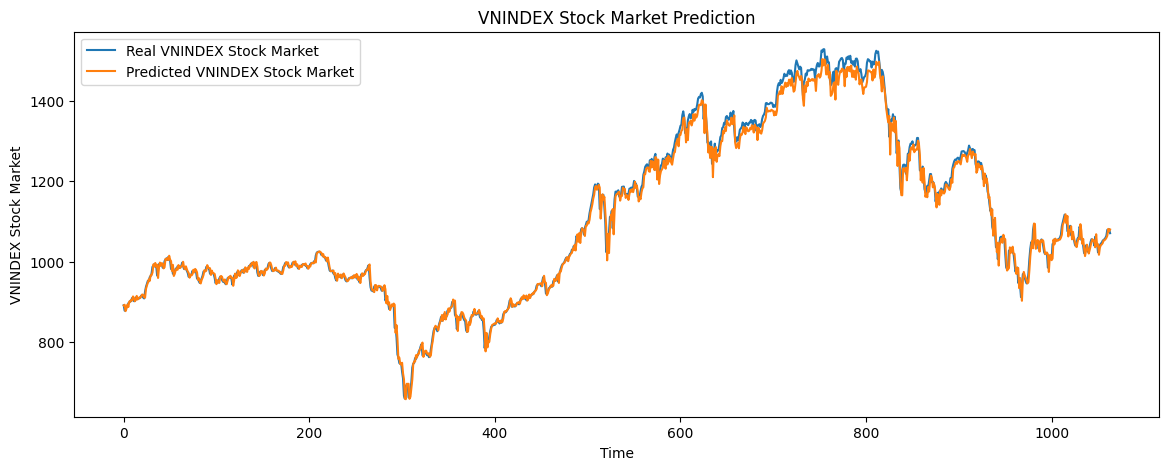

In [67]:
# Evaluate on testing set
# Part 3 - Making the predictions and visualising the results

# Getting the real stock price of 2023

real_stock_price_LSTM = df_test.iloc[:,3:4].values
# Getting the predicted stock price of 2023
# We need 60 previous inputs for each day of the Test_set in 2023 
# Combine 'dataset_train' and 'dataset_test'
# 'axis = 0' for Vertical Concatenation to add rows to the bottom
dataset_total_LSTM = pd.concat((df_train['Close'], df_test['Close']), axis = 0)
# Extract Stock Prices for Test time period, plus 60 days previous
inputs_LSTM = dataset_total_LSTM[len(dataset_total_LSTM) - len(df_test) - 60:].values
# 'reshape' function to get it into a NumPy format
inputs_LSTM = inputs_LSTM.reshape(-1,1)
# Inputs need to be scaled to match the model trained on Scaled Feature
inputs_LSTM = sc.transform(inputs_LSTM)
# The following is pasted from above and modified for Testing, romove all 'Ys'
X_test = []

for i in range(60, 60+len(df_test)):
    X_test.append(inputs_LSTM[i-60:i, 0])

X_test = np.array(X_test)
# We need a 3D input so add another dimension
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
# Predict the Stock Price
predicted_stock_price_LSTM = regressor.predict(X_test)
# We need to inverse the scaling of our prediction to get a Dollar amount
predicted_stock_price_LSTM = sc.inverse_transform(predicted_stock_price_LSTM)

# Visualising the results
plt.figure(figsize=(14,5))
plt.style.context('fivethirtyeight')
plt.plot(real_stock_price_LSTM, label = 'Real VNINDEX Stock Market')
plt.plot(predicted_stock_price_LSTM, label = 'Predicted VNINDEX Stock Market')
plt.title('VNINDEX Stock Market Prediction')
plt.xlabel('Time')
plt.ylabel('VNINDEX Stock Market')
plt.legend()
plt.show()

In [68]:
print('MAE: ',mean_absolute_error(real_stock_price_LSTM,predicted_stock_price_LSTM))
print('MSE: ',mean_squared_error(real_stock_price_LSTM,predicted_stock_price_LSTM))
print('RMSE: ',np.sqrt(mean_squared_error(real_stock_price_LSTM,predicted_stock_price_LSTM)))
print('Variance Regression Score: ',explained_variance_score(real_stock_price_LSTM,predicted_stock_price_LSTM))

MAE:  12.884355489400992
MSE:  324.0583930004544
RMSE:  18.00162195471437
Variance Regression Score:  0.9932575869803275


In [69]:
from keras.layers import GRU

model = Sequential()

model.add(GRU(units = 100, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(GRU(units = 100, return_sequences = False))
model.add(Dropout(0.2))

model.add(Dense(units = 1))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')

model.fit(X_train, y_train, epochs = 50, batch_size = 32)

Epoch 1/50
137/137 [==============================] - 5s 10ms/step - loss: 0.0046
Epoch 2/50
137/137 [==============================] - 2s 13ms/step - loss: 0.0011
Epoch 3/50
137/137 [==============================] - 2s 12ms/step - loss: 9.2842e-04
Epoch 4/50
137/137 [==============================] - 2s 13ms/step - loss: 9.0768e-04
Epoch 5/50
137/137 [==============================] - 2s 11ms/step - loss: 7.1885e-04
Epoch 6/50
137/137 [==============================] - 2s 12ms/step - loss: 7.6887e-04
Epoch 7/50
137/137 [==============================] - 2s 12ms/step - loss: 7.2436e-04
Epoch 8/50
137/137 [==============================] - 2s 14ms/step - loss: 7.1402e-04
Epoch 9/50
137/137 [==============================] - 2s 16ms/step - loss: 6.4616e-04
Epoch 10/50
137/137 [==============================] - 2s 13ms/step - loss: 6.4290e-04
Epoch 11/50
137/137 [==============================] - 2s 12ms/step - loss: 5.7793e-04
Epoch 12/50
137/137 [==============================] - 2s 11

In [70]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_5 (GRU)                 (None, 60, 100)           30900     
                                                                 
 dropout_6 (Dropout)         (None, 60, 100)           0         
                                                                 
 gru_6 (GRU)                 (None, 100)               60600     
                                                                 
 dropout_7 (Dropout)         (None, 100)               0         
                                                                 
 dense_6 (Dense)             (None, 1)                 101       
                                                                 
Total params: 91,601
Trainable params: 91,601
Non-trainable params: 0
_________________________________________________________________


34/34 [==============================] - 1s 5ms/step


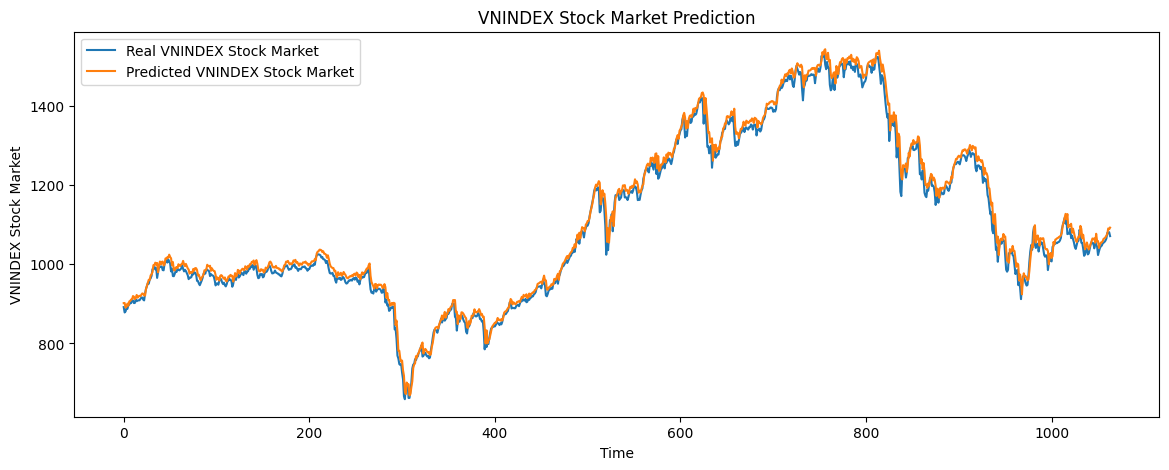

In [71]:
real_stock_price_gru = df_test.iloc[:,3:4].values

dataset_total_gru = pd.concat((df_train['Close'], df_test['Close']), axis = 0)
inputs_gru = dataset_total_gru[len(dataset_total_gru) - len(df_test) - 60:].values

inputs_gru = inputs_gru.reshape(-1,1)

inputs_gru = sc.transform(inputs_gru)

X_test = []

for i in range(60, 60 + len(df_test)):
    X_test.append(inputs_gru[i-60:i, 0])

X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

predicted_stock_price_gru = model.predict(X_test)

predicted_stock_price_gru = sc.inverse_transform(predicted_stock_price_gru)

plt.figure(figsize=(14,5))
plt.style.context('fivethirtyeight')
plt.plot(real_stock_price_gru, label = 'Real VNINDEX Stock Market')
plt.plot(predicted_stock_price_gru, label = 'Predicted VNINDEX Stock Market')
plt.title('VNINDEX Stock Market Prediction')
plt.xlabel('Time')
plt.ylabel('VNINDEX Stock Market')
plt.legend()
plt.show()

In [72]:
print('MAE: ',mean_absolute_error(real_stock_price_gru,predicted_stock_price_gru))
print('MSE: ',mean_squared_error(real_stock_price_gru,predicted_stock_price_gru))
print('RMSE: ',np.sqrt(mean_squared_error(real_stock_price_gru,predicted_stock_price_gru)))
print('Variance Regression Score: ',explained_variance_score(real_stock_price_gru,predicted_stock_price_gru))

MAE:  15.02719589118671
MSE:  406.03388553480994
RMSE:  20.150282517493643
Variance Regression Score:  0.9946269589803567


In [73]:
combine = Sequential()

combine.add(LSTM(units = 100, return_sequences = True, input_shape = (X_train.shape[1], 1)))
combine.add(Dropout(0.2))

combine.add(GRU(units = 100, return_sequences = False))
combine.add(Dropout(0.2))

combine.add(Dense(units = 1))

combine.compile(optimizer = 'adam', loss = 'mean_squared_error')

combine.fit(X_train, y_train, epochs = 50, batch_size = 32)

Epoch 1/50
137/137 [==============================] - 6s 10ms/step - loss: 0.0050
Epoch 2/50
137/137 [==============================] - 1s 7ms/step - loss: 0.0011
Epoch 3/50
137/137 [==============================] - 1s 7ms/step - loss: 0.0011
Epoch 4/50
137/137 [==============================] - 1s 7ms/step - loss: 9.8498e-04
Epoch 5/50
137/137 [==============================] - 1s 7ms/step - loss: 8.5709e-04
Epoch 6/50
137/137 [==============================] - 1s 7ms/step - loss: 9.1522e-04
Epoch 7/50
137/137 [==============================] - 1s 7ms/step - loss: 9.7064e-04
Epoch 8/50
137/137 [==============================] - 1s 7ms/step - loss: 8.4649e-04
Epoch 9/50
137/137 [==============================] - 1s 7ms/step - loss: 8.1546e-04
Epoch 10/50
137/137 [==============================] - 1s 7ms/step - loss: 8.6424e-04
Epoch 11/50
137/137 [==============================] - 1s 8ms/step - loss: 6.9251e-04
Epoch 12/50
137/137 [==============================] - 1s 10ms/step - loss

34/34 [==============================] - 1s 3ms/step


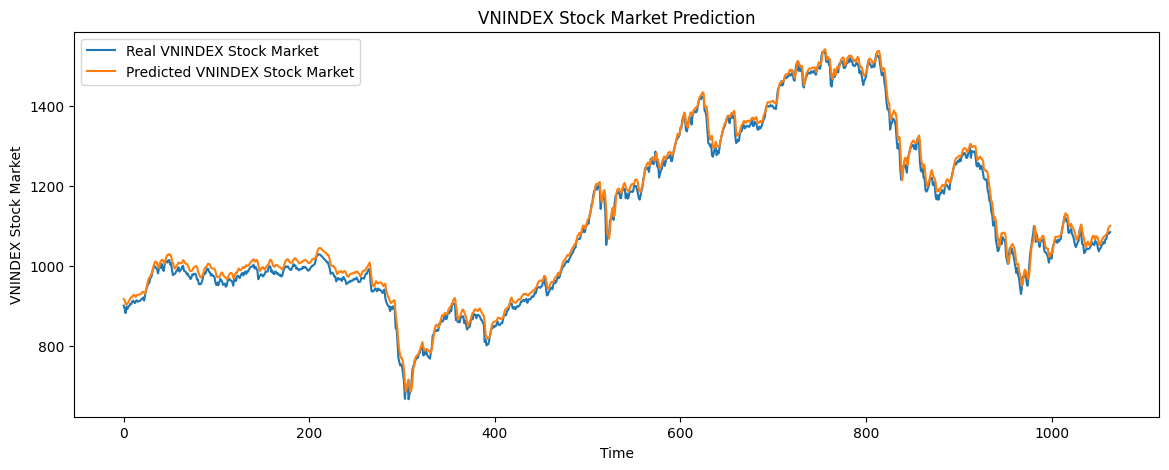

In [74]:
real_stock_price_combine = df_test.iloc[:, 1:2].values

dataset_total_combine = pd.concat((df_train['Close'], df_test['Close']), axis = 0)
inputs_combine = dataset_total_combine[len(dataset_total_combine) - len(df_test) - 60:].values

inputs_combine = inputs_combine.reshape(-1,1)

inputs_combine = sc.transform(inputs_combine)

X_test = []

for i in range(60, 60+len(df_test)):
    X_test.append(inputs_combine[i-60:i, 0])

X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

predicted_stock_price_combine = combine.predict(X_test)

predicted_stock_price_combine = sc.inverse_transform(predicted_stock_price_combine)

plt.figure(figsize=(14,5))
plt.style.context('fivethirtyeight')
plt.plot(real_stock_price_combine, label = 'Real VNINDEX Stock Market')
plt.plot(predicted_stock_price_combine, label = 'Predicted VNINDEX Stock Market')
plt.title('VNINDEX Stock Market Prediction')
plt.xlabel('Time')
plt.ylabel('VNINDEX Stock Market')
plt.legend()
plt.show()

In [75]:
print('MAE: ',mean_absolute_error(real_stock_price_combine,predicted_stock_price_combine))
print('MSE: ',mean_squared_error(real_stock_price_combine,predicted_stock_price_combine))
print('RMSE: ',np.sqrt(mean_squared_error(real_stock_price_combine,predicted_stock_price_combine)))
print('Variance Regression Score: ',explained_variance_score(real_stock_price_combine,predicted_stock_price_combine))

MAE:  14.253295538192402
MSE:  280.72741389446225
RMSE:  16.754922079629683
Variance Regression Score:  0.9974207944816298
